## Exercise 2.5 - Non-Stationary Problem
 
Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for
non-stationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start
out equal and then take independent random walks (say by adding a normally distributed increment with
mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2
for an action-value method using sample averages, incrementally computed, and another action-value
method using a constant step-size parameter, $\alpha$=0.1. Use $\epsilon$=0.1 and longer runs, say of
10,000 steps.

In [ ]:
# !pip3 -q install numpy gym matplotlib ray
# !pip uninstall grpcio; conda install grpcio
# !pip install ray
# !pip -q install gymnasium
# !pip install "gymnasium[all]"


In [10]:
import gymnasium as gym
import ray
# import gym
# import gym.spaces
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from bandit import run_episode
from gamblers import Gambler, AveragingGambler, EpsilonGreedyGambler

In [ ]:
gym.register(id='ArmedBanditTestbed-v0',  
             entry_point='gym_other_env:ArmedBanditTestbedEnv',
             kwargs={'param1': value1})  

### Bandit Testbed (Stationary and Non-Stationary)

In [11]:
n = 10

class RandomGambler(Gambler):
    def arm(self):
        return self.np_random.choice(n)

random_gambler = RandomGambler()

In [12]:
stationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True)
stationary.reset()
stationary.render()
run_episode(stationary, random_gambler)   
stationary.render()

NameNotFound: Environment ArmedBanditTestbed doesn't exist. 

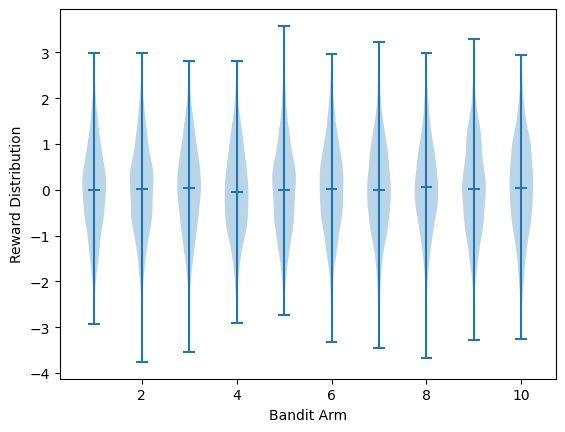

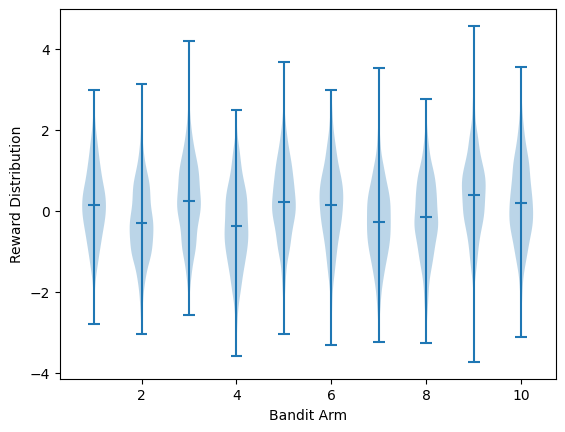

In [4]:
nonstationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False)
nonstationary.reset()

nonstationary.render()
run_episode(nonstationary, random_gambler)   
nonstationary.render()

#### Random Seed Repeatability

In [5]:
rewards0, corrects0, _ = run_episode(stationary, random_gambler, 7)
rewards1, corrects1, _ = run_episode(stationary, random_gambler, 7)

assert np.all(rewards0 == rewards1)
assert np.all(corrects0 == corrects1)

In [6]:
rewards0, corrects0, _ = run_episode(nonstationary, random_gambler, 7)
rewards1, corrects1, _ = run_episode(nonstationary, random_gambler, 7)

assert np.all(rewards0 == rewards1)
assert np.all(corrects0 == corrects1)

### Reproduction of Figure 2.2

In [7]:
ray.init(object_store_memory=1_000_000_000)


@ray.remote
def ray_episode(bandit, gambler, seed):
    rewards, corrects, steps = run_episode(bandit, gambler, seed)
    return rewards, corrects


def run_experiments(bandit, gamblers, num_episodes):
    bandit_id = ray.put(bandit)
    
    experiments = {}
    for label, gambler in gamblers.items():

        gambler_id = ray.put(gambler)
        seed = np.random.randint(2 ** 32 - 1 - num_episodes)
        episodes = [ray_episode.remote(bandit_id, gambler_id, seed + i) for i in range(num_episodes)]

        rewards, corrects = 0, 0
        while episodes:
            finished, episodes = ray.wait(episodes)
            eprews, epcors = ray.get(finished[0])
            rewards += (eprews - rewards) / (num_episodes - len(episodes))
            corrects += epcors

        experiments[label] = (rewards, corrects / num_episodes)

    return experiments

2023-05-09 10:11:58,720	INFO worker.py:1625 -- Started a local Ray instance.


In [8]:
matplotlib.rcParams['figure.figsize'] = [10, 5]
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=['g', 'b', 'r'])

def plot_experiments(results):
    fig_rewards = plt.figure()
    fig_corrects = plt.figure()


    for label, (rewards, corrects) in results.items():
        fig_rewards.gca().plot(rewards, label=label)
        fig_corrects.gca().plot(corrects, label=label)

    fig_rewards.gca().set_ylabel("Average reward")
    fig_rewards.gca().set_xlabel("Steps")
    fig_rewards.legend()
    
    fig_corrects.gca().set_ylabel("Optimal action")
    fig_corrects.gca().set_xlabel("Steps")
    fig_corrects.legend()

In [9]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True) 

gamblers = {
    r"greedy": AveragingGambler(n, epsilon=0),
    r"$\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"$\epsilon$ = 0.01": AveragingGambler(n, epsilon=0.01)
}

experiments = run_experiments(bandit, gamblers, num_episodes=4_000)
plot_experiments(experiments)

ValueError: high is out of bounds for int32

### Sample Averaged and Fixed Step Gambler in a Non-Stationary Problem

In [ ]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False) 
bandit._max_episode_steps = 100_000

gamblers = {
    r"Averaging: $\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"FixedStep: $\epsilon$ = 0.1, $\alpha$ = 0.1": EpsilonGreedyGambler(n, epsilon=0.1, alpha=0.1),
}

experiments = run_experiments(bandit, gamblers, num_episodes=100)
plot_experiments(experiments)